## Import Libraries

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from typing import Optional, List, Dict, Union
import matplotlib.pyplot as plt

## Scrape Web Pages for Tables of Unicorn Startups

In [ ]:
class UnicornCompaniesScraper:
    def __init__(
        self,
        url_indices: Union[Dict[str, List[int]], List[Dict[str, List[int]]]],
        proxy: Optional[Dict[str, str]] = None,
    ):
        """
        Initialize the scraper with a dictionary (or list of dictionaries) mapping URLs to table indices.
        Optionally, provide a proxy configuration.
        """
        if isinstance(url_indices, dict):
            self.url_indices = [url_indices]
        else:
            self.url_indices = url_indices
        self.proxy = proxy
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

    def fetch_webpage(self, url: str) -> Optional[str]:
        """
        Fetch the webpage content using an optional proxy.
        """
        try:
            response = requests.get(url, headers=self.headers, proxies=self.proxy)
            response.raise_for_status()
            return response.content
        except requests.exceptions.RequestException as e:
            print(f"Failed to fetch the webpage ({url}): {e}")
            return None

    def parse_tables(
        self, html_content: str, table_indices: List[int]
    ) -> List[pd.DataFrame]:
        """
        Parse specific tables from the HTML content based on their indices.
        """
        soup = BeautifulSoup(html_content, "html.parser")
        tables = soup.find_all("table")
        dataframes = []

        for index in table_indices:
            if index < len(tables):
                table = tables[index]
                # Extract table headers
                headers = [header.text.strip() for header in table.find_all("th")]
                # Extract table rows
                rows = []
                for row in table.find_all("tr"):
                    cells = [cell.text.strip() for cell in row.find_all("td")]
                    if cells:
                        rows.append(cells)
                # Create a DataFrame
                df = pd.DataFrame(rows, columns=headers)
                dataframes.append(df)
            else:
                print(f"Table index {index} is out of range for the current webpage.")

        return dataframes

    def save_to_csv(
        self, dataframes: List[pd.DataFrame], base_filename: str, url: str
    ) -> None:
        """
        Save the list of DataFrames to CSV files.
        """
        for i, df in enumerate(dataframes):
            # Create a unique filename using the base filename, URL, and table index
            filename = (
                f"{base_filename}_{url.split('//')[-1].replace('/', '_')}_table_{i}.csv"
            )
            try:
                df.to_csv(filename, index=False)
                print(f"Data saved to {filename}")
            except Exception as e:
                print(f"Failed to save data to CSV ({filename}): {e}")

    def run(self, base_filename: str = "unicorn_companies") -> None:
        """
        Run the scraper for all URLs and save the results.
        """
        for url_indices in self.url_indices:
            for url, table_indices in url_indices.items():
                print(f"Processing URL: {url}")
                html_content = self.fetch_webpage(url)
                if html_content:
                    dataframes = self.parse_tables(html_content, table_indices)
                    if dataframes:
                        self.save_to_csv(dataframes, base_filename, url)


url_indices = {
    "https://www.cbinsights.com/research-unicorn-companies": [0],
}

scraper = UnicornCompaniesScraper(url_indices)
scraper.run(base_filename="unicorn_data")


## Analyze Extracted Data about Unicorns Startups

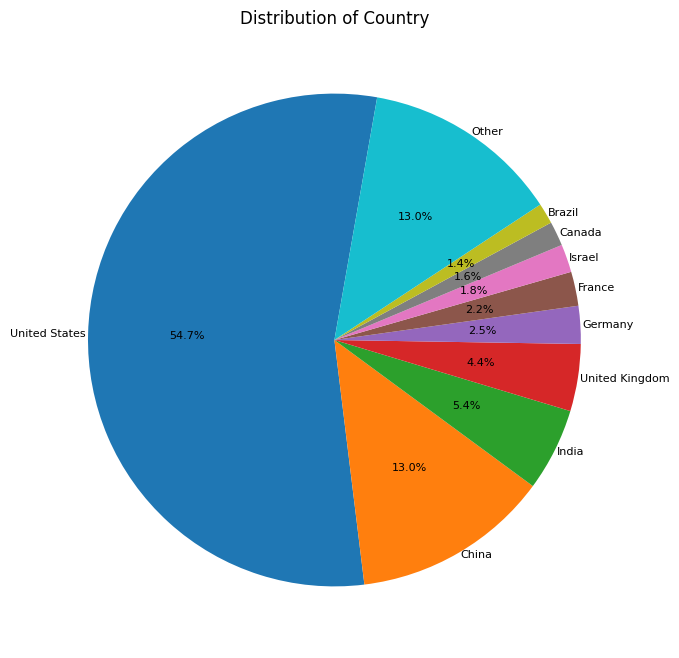

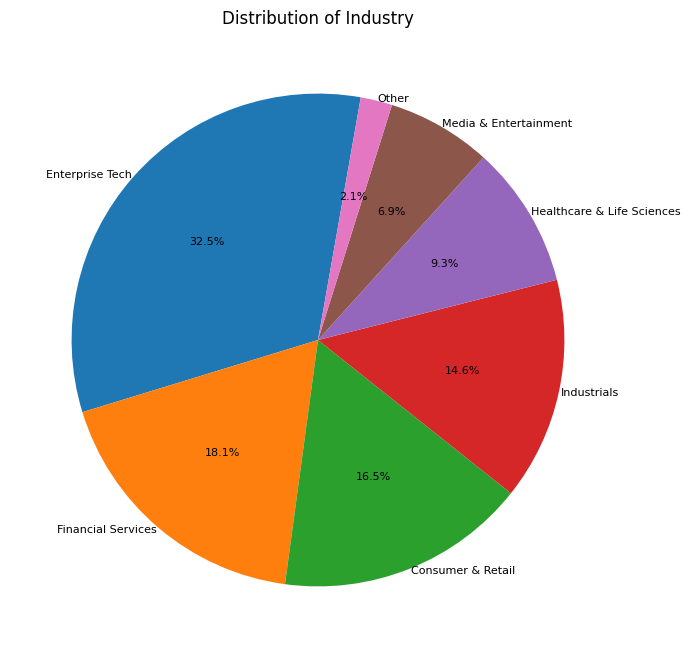

In [5]:

class DataAnalyzer:
    """Class for analyzing CSV data and plotting pie charts for specified columns."""

    def __init__(self, file_path: str):
        self.data = pd.read_csv(file_path)

    def preprocess_column(self, column_name: str, top_n: int) -> pd.Series:
        """Prepares data for pie chart by grouping less frequent values into 'Other'."""
        value_counts = self.data[column_name].value_counts()
        top_values = value_counts.nlargest(top_n)
        other_count = value_counts.iloc[top_n:].sum()
        prepared_data = top_values

        if other_count > 0:
            prepared_data['Other'] = other_count

        return prepared_data

    def plot_pie_chart(self, column_name: str, top_n: int):
        """Plots a pie chart for the given column with a specified number of pies."""
        data = self.preprocess_column(column_name, top_n)
        plt.figure(figsize=(8, 8))
        
        data.plot.pie(
            autopct="%1.1f%%",
            startangle=80,
            textprops={'fontsize': 8},
            labeldistance=1.01,
        )
        plt.title(f"Distribution of {column_name}")
        plt.ylabel("")
        plt.show()


file_path = "unicorn_data_www.cbinsights.com_research-unicorn-companies_table_0.csv"  # Replace with your file path
analyzer = DataAnalyzer(file_path)

analyzer.plot_pie_chart("Country", top_n=9)
analyzer.plot_pie_chart("Industry", top_n=6)
